# Iterating over multiple refutation tests
The objective of this notebook is to compare the ability of refuters to detect the problems in a given set of estimators.
Note:
This notebook makes use of the optional dependencies:
- pygraphviz
- econml

## Import Dependencies

In [23]:
from dowhy.datasets import linear_dataset
from dowhy import CausalModel
import econml

# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

## Inspection Parameters
These parameters give us the option of inspecting the intermediate steps to sanity check the steps performed

In [24]:
inspect_datasets = True
inspect_models = True
inspect_identified_estimands = True
inspect_estimates = True
inspect_refutations = True

## Estimator List
We pass a list of strings, corresponding to the estimators of interest

In [25]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

estimator_list = ["backdoor.propensity_score_matching", "backdoor.propensity_score_weighting", "backdoor.econml.dml.DML"]
method_params= [ None, None, {"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=False)},
                                               "fit_params":{}} ]

## Refuter List
A list of strings, corresponding to each refuter we wish to run

In [26]:
refuter_list = ["bootstrap_refuter", "data_subset_refuter"]

## Create the Datasets

In [27]:
# Parameters for creating the Dataset
TREATMENT_IS_BINARY = True
BETA = 10
NUM_SAMPLES = 5000
NUM_CONFOUNDERS = 5
NUM_INSTRUMENTS = 3
NUM_EFFECT_MODIFIERS = 2

# Creating a Linear Dataset with the given parameters
linear_data = linear_dataset(
            beta = BETA,
            num_common_causes = NUM_CONFOUNDERS,
            num_instruments = NUM_INSTRUMENTS,
            num_effect_modifiers = NUM_EFFECT_MODIFIERS,
            num_samples = NUM_SAMPLES,
            treatment_is_binary = True
        )
# Other datasets come here 


# Append them together in an array
datasets = [linear_data]


## Inspect Data

In [28]:
dataset_num = 1
if inspect_datasets is True:
    for data in datasets:
        print("####### Dataset {}###########################################################################################".format(dataset_num))
        print(data['df'].head())
        print("#############################################################################################################")
        dataset_num += 1

####### Dataset 1###########################################################################################
         X0        X1   Z0        Z1   Z2        W0        W1        W2  \
0  1.967335  1.905424  1.0  0.670757  0.0 -0.202865 -1.144348  1.183711   
1  1.128093 -1.239441  0.0  0.867080  0.0 -0.356516  1.708609  1.092528   
2  1.652412 -0.091724  1.0  0.571701  0.0 -0.932946 -2.417561  0.628134   
3 -1.435738  0.029290  1.0  0.107491  0.0 -0.573645 -1.436408 -0.625384   
4  1.811213  0.656676  1.0  0.789946  0.0 -1.196961 -1.909887  0.436464   

         W3        W4    v0          y  
0  0.936799 -0.174390  True  12.717473  
1 -0.040246 -1.029646  True  15.072868  
2 -1.921820  0.121284  True  -9.638836  
3  1.963276 -1.014058  True   5.584867  
4 -0.035781 -0.435584  True  -2.168388  
#############################################################################################################


## Create the CausalModels

In [29]:
models = []
for data in datasets:
    model = CausalModel(
                data = data['df'],
                treatment = data['treatment_name'],
                outcome = data['outcome_name'],
                graph = data['gml_graph']
            )
    models.append(model)

## View Models

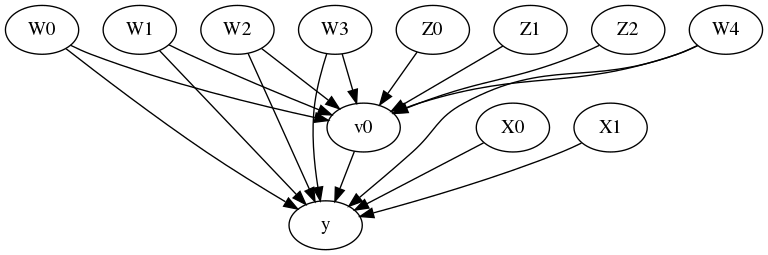

In [30]:
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

## Identify Effect

In [31]:
identified_estimands = []
for model in models:
    identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
    identified_estimands.append(identified_estimand)

## Identified Estimands

In [32]:
estimand_count = 1
for estimand in identified_estimands:
    print("####### Identified Estimand {}#####################################################################################".format(estimand_count))
    print(estimand)
    print("###################################################################################################################")
    estimand_count += 1

####### Identified Estimand 1#####################################################################################
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W1,W4,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z1, Z0, Z2])*Derivative([v0], [Z1, Z0, Z2])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0,Z2})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0,Z2}→{v0}, then ¬({Z1,Z0,Z2}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

###################################################################################################################


## Estimate Effect

In [33]:
estimate_list = []
for i in range(len(identified_estimands)):
    for j in range(len(estimator_list)):
        estimate = model.estimate_effect(
                        identified_estimands[i],
                        method_name=estimator_list[j],
                        method_params=method_params[j]
                  )
        estimate_list.append(estimate)

## Estimate Values

In [34]:
estimand_count = 1
if inspect_estimates is True:
    for estimand in estimate_list:
        print("####### Estimand {}#######################################################################################".format(estimand_count))
        print("*** Class Name ***")
        print()
        print(estimand.params['estimator_class'])
        print()
        print(estimand)
        print("########################################################################################################")
        print()
        estimand_count += 1
    

####### Estimand 1#######################################################################################
*** Class Name ***

<class 'dowhy.causal_estimators.propensity_score_matching_estimator.PropensityScoreMatchingEstimator'>

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                 
─────(Expectation(y|W0,W1,W4,W3,W2))
d[v₀]                               
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W4,W3,W2,U) = P(y|v0,W0,W1,W4,W3,W2)

## Realized estimand
b: y~v0+W0+W1+W4+W3+W2
Target units: ate

## Estimate
Mean value: 8.974926096306975

########################################################################################################

####### Estimand 2#######################################################################################
*** Class Name ***

<class 'dowhy.causal_estimators.propensity_score_weighting_est

## Refute Estimate

In [35]:
refutation_list = []
for estimand in identified_estimands:
    for estimate in estimate_list: 
        for refuter in refuter_list:
            ref = model.refute_estimate(estimand, estimate,method_name=refuter)
            refutation_list.append(ref)

## Refutation Values

In [36]:
refuter_count = 1
if inspect_refutations is True:
    for refutation in refutation_list:
        print("####### Refutation {}#######################################################################################".format(refuter_count))
        print("*** Class Name ***")
        print()
        print(refutation.refutation_type)
        print()
        print(refutation)
        print("########################################################################################################")
        print()
        refuter_count += 1

####### Refutation 1#######################################################################################
*** Class Name ***

Refute: Bootstrap Sample Dataset

Refute: Bootstrap Sample Dataset
Estimated effect:8.974926096306975
New effect:9.710002131986627
p value:0.25

########################################################################################################

####### Refutation 2#######################################################################################
*** Class Name ***

Refute: Use a subset of data

Refute: Use a subset of data
Estimated effect:8.974926096306975
New effect:9.859343600595292
p value:0.1

########################################################################################################

####### Refutation 3#######################################################################################
*** Class Name ***

Refute: Bootstrap Sample Dataset

Refute: Bootstrap Sample Dataset
Estimated effect:12.408983841921629
New effect:12.497225